# Part 2: Train LLM-based Credit Risk Model

In this notebook, we'll train a credit risk model that combines structured data with text embeddings from loan application descriptions. We'll use both traditional machine learning and modern LLM techniques.

## Main Objectives
- Process text data using embeddings
- Combine structured and unstructured data
- Train and evaluate classification models
- Compare different modeling approaches
- Understand the value of text data in credit risk

## Setup and Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import openai
from transformers import AutoTokenizer, AutoModel
import torch
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# from google.colab import drive
# drive.mount('/content/drive')

print("Libraries imported successfully!")

c:\Users\Pinter Andrea\src\LLMsInFinance\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!


In [ ]:
# Load the dataset from the previous notebook
import json

with open('credit_applications_dataset.json', 'r') as f:
    dataset = json.load(f)

df = pd.DataFrame(dataset['data'])

print(f"Dataset loaded: {df.shape}")
print(f"Columns: {list(df.columns)}")

df.head()

Dataset loaded: (200, 15)
Columns: ['applicant_id', 'age', 'income', 'purpose', 'loan_amount', 'credit_history', 'employment_length', 'debt_to_income', 'location', 'education', 'criminal_record', 'text_description', 'default_probability', 'no_default_probability', 'predicted_token']


,applicant_id,age,income,purpose,loan_amount,credit_history,employment_length,debt_to_income,location,education,criminal_record,text_description,default_probability,no_default_probability,predicted_token
0,APP_000001,34,55000,debt_consolidation,15000,fair,8.5,0.35,CA,bachelors,no,"I am seeking a loan of $15,000 for debt consol...",0.0086,0.9914,ND
1,APP_000002,34,52000,debt_consolidation,15000,fair,6.5,0.35,CA,some_college,no,I am a 34-year-old resident of California with...,0.0000,1.0000,ND
2,APP_000003,34,52000,debt_consolidation,15000,fair,5.5,0.35,CA,bachelors,no,I am a 34-year-old professional living in Cali...,0.2227,0.7773,ND
3,APP_000004,34,48000,debt_consolidation,15000,fair,8.5,0.35,CA,bachelors,no,I am a 34-year-old with a stable income of $48...,0.4378,0.5622,ND
4,APP_000005,34,55000,debt_consolidation,12000,fair,5.2,0.35,CA,bachelors,no,"I am seeking a loan of $12,000 for debt consol...",0.8808,0.1192,D


## Prepare Structured Features

First, let's process the structured data features:

In [4]:
def prepare_structured_features(df):
    """Prepare structured features for modeling"""

    # Select structured features
    structured_features = ['age', 'income', 'loan_amount', 'employment_length', 'debt_to_income']

    # Create feature matrix
    X_structured = df[structured_features].copy()

    # Add derived features
    X_structured['loan_to_income_ratio'] = df['loan_amount'] / df['income']
    X_structured['log_income'] = np.log1p(df['income'])
    X_structured['log_loan_amount'] = np.log1p(df['loan_amount'])

    # Encode categorical variables
    le_purpose = LabelEncoder()
    X_structured['purpose_encoded'] = le_purpose.fit_transform(df['purpose'])

    le_credit = LabelEncoder()
    X_structured['credit_history_encoded'] = le_credit.fit_transform(df['credit_history'])

    # Encode education and location if they exist
    if 'education' in df.columns:
        le_education = LabelEncoder()
        X_structured['education_encoded'] = le_education.fit_transform(df['education'])

    if 'location' in df.columns:
        le_location = LabelEncoder()
        X_structured['location_encoded'] = le_location.fit_transform(df['location'])

    return X_structured, le_purpose, le_credit

# Prepare structured features
X_structured, le_purpose, le_credit = prepare_structured_features(df)

print(f"Structured features shape: {X_structured.shape}")
print(f"Features: {list(X_structured.columns)}")

# Show statistics
X_structured.describe()

Structured features shape: (200, 12)
Features: ['age', 'income', 'loan_amount', 'employment_length', 'debt_to_income', 'loan_to_income_ratio', 'log_income', 'log_loan_amount', 'purpose_encoded', 'credit_history_encoded', 'education_encoded', 'location_encoded']


,age,income,loan_amount,employment_length,debt_to_income,loan_to_income_ratio,log_income,log_loan_amount,purpose_encoded,credit_history_encoded,education_encoded,location_encoded
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.0
mean,34.010000,60585.000000,14790.000000,7.672500,0.334150,0.248862,11.001184,9.598990,0.0,0.080000,0.145000,0.0
std,1.147381,8893.720612,1091.723086,1.774327,0.034237,0.037659,0.146016,0.075594,0.0,0.289862,0.352984,0.0
min,29.000000,45000.000000,12000.000000,2.500000,0.250000,0.176471,10.714440,9.392745,0.0,0.000000,0.000000,0.0
25%,34.000000,55000.000000,15000.000000,6.500000,0.350000,0.208333,10.915107,9.615872,0.0,0.000000,0.000000,0.0
50%,34.000000,58000.000000,15000.000000,8.500000,0.350000,0.250000,10.968216,9.615872,0.0,0.000000,0.000000,0.0
75%,34.000000,65750.000000,15000.000000,8.500000,0.350000,0.272727,11.093438,9.615872,0.0,0.000000,0.000000,0.0
max,45.000000,75000.000000,20000.000000,10.500000,0.450000,0.333333,11.225257,9.903538,0.0,2.000000,1.000000,0.0


## Generate Text Embeddings

Now let's create embeddings from the text descriptions using different approaches:

In [5]:
import os
from openai import OpenAI
from tqdm import tqdm
import time
import numpy as np
# from google.colab import userdata


# Initialize OpenAI client
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

def get_openai_embeddings(texts, model="text-embedding-3-small"):
    """
    Get embeddings using OpenAI API with proper error handling and rate limiting.
    Based on the approach from comparable_selection.ipynb
    """

    embeddings = []

    print(f"Generating embeddings for {len(texts)} texts using {model}")

    for i, text in enumerate(tqdm(texts, desc="Generating embeddings")):
        try:
            # Create embedding request
            response = client.embeddings.create(
                input=text,
                model=model
            )

            # Extract embedding vector
            embedding = response.data[0].embedding
            embeddings.append(embedding)

            # Rate limiting - small delay to avoid hitting API limits
            time.sleep(0.01)

        except Exception as e:
            print(f"Error processing text {i}: {e}")
            # If there's an error, add a zero vector of the expected dimension
            # We'll use the first successful embedding to determine the dimension
            if embeddings:
                embedding = [0.0] * len(embeddings[0])
            else:
                # Default dimension for text-embedding-3-small
                embedding = [0.0] * 1536
            embeddings.append(embedding)

    return np.array(embeddings)

# Generate embeddings for all text descriptions
texts = df['text_description'].tolist()
print(f"Processing {len(texts)} text descriptions...")

embeddings = get_openai_embeddings(texts)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Embedding dimension: {embeddings.shape[1]}")

# Save embeddings for later use
np.save('credit_text_embeddings.npy', embeddings)
print("Embeddings saved to credit_text_embeddings.npy")

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

## Combine Structured and Text Features

Now let's create combined feature matrices:

In [6]:
# Prepare different feature combinations
def create_feature_combinations(X_structured, embeddings):
    """Create different feature combinations for comparison"""

    # 1. Only structured features
    X_structured_only = X_structured.copy()

    # 2. Only text embeddings
    X_text_only = embeddings

    # 3. Combined features
    X_combined = np.concatenate([X_structured.values, embeddings], axis=1)

    return X_structured_only, X_text_only, X_combined

# Create feature combinations
X_structured_only, X_text_only, X_combined = create_feature_combinations(X_structured, embeddings)

print(f"Structured only: {X_structured_only.shape}")
print(f"Text only: {X_text_only.shape}")
print(f"Combined: {X_combined.shape}")

# Target variable, based on the probabilities of default and not default
y = df['default_probability'].values > df['no_default_probability'].values

print(f"Target distribution: {np.bincount(y)}")
print(f"Default rate: {y.mean():.2%}")

Structured only: (200, 12)
Text only: (200, 1536)
Combined: (200, 1548)
Target distribution: [163  37]
Default rate: 18.50%


## Train and Evaluate Models

Let's train different models and compare their performance:

In [7]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_type):
    """Train multiple models and evaluate their performance"""

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500)
    }

    results = {}

    for name, model in models.items():
        print(f"Training {name} with {feature_type} features...")

        # Train model
        model.fit(X_train_scaled, y_train)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)

        results[name] = {
            'model': model,
            'scaler': scaler,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'auc_score': auc_score,
            'avg_precision': avg_precision,
            'y_test': y_test  # Store y_test for later analysis
        }

        print(f"  AUC: {auc_score:.4f}")
        print(f"  Avg Precision: {avg_precision:.4f}")
        print()

    return results

# Split data
test_size = 0.2
random_state = 42

# Results dictionary to store all experiments
all_results = {}

# Feature combinations to test
feature_combinations = [
    (X_structured_only, "Structured Only"),
    (X_text_only, "Text Only"),
    (X_combined, "Combined")
]

# Store test indices for later analysis
test_indices = None

for X_data, feature_type in feature_combinations:
    print(f"\n{'='*50}")
    print(f"TRAINING WITH {feature_type.upper()} FEATURES")
    print(f"{'='*50}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Store test indices for the first split (they'll be the same for all)
    if test_indices is None:
        # Get indices for the test set
        _, test_indices = train_test_split(
            range(len(X_data)), test_size=test_size, random_state=random_state, stratify=y
        )

    # Train and evaluate models
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_type)
    all_results[feature_type] = results




TRAINING WITH STRUCTURED ONLY FEATURES
Training Logistic Regression with Structured Only features...
  AUC: 0.4307
  Avg Precision: 0.1691

Training Random Forest with Structured Only features...
  AUC: 0.4286
  Avg Precision: 0.1729

Training Neural Network with Structured Only features...
  AUC: 0.5909
  Avg Precision: 0.2231


TRAINING WITH TEXT ONLY FEATURES
Training Logistic Regression with Text Only features...
  AUC: 0.5628
  Avg Precision: 0.2619

Training Random Forest with Text Only features...
  AUC: 0.6255
  Avg Precision: 0.2721

Training Neural Network with Text Only features...
  AUC: 0.6320
  Avg Precision: 0.3678


TRAINING WITH COMBINED FEATURES
Training Logistic Regression with Combined features...
  AUC: 0.6017
  Avg Precision: 0.3757

Training Random Forest with Combined features...
  AUC: 0.7056
  Avg Precision: 0.3758

Training Neural Network with Combined features...
  AUC: 0.6926
  Avg Precision: 0.3622



## Model Performance Comparison

Let's visualize and compare the performance of different models:

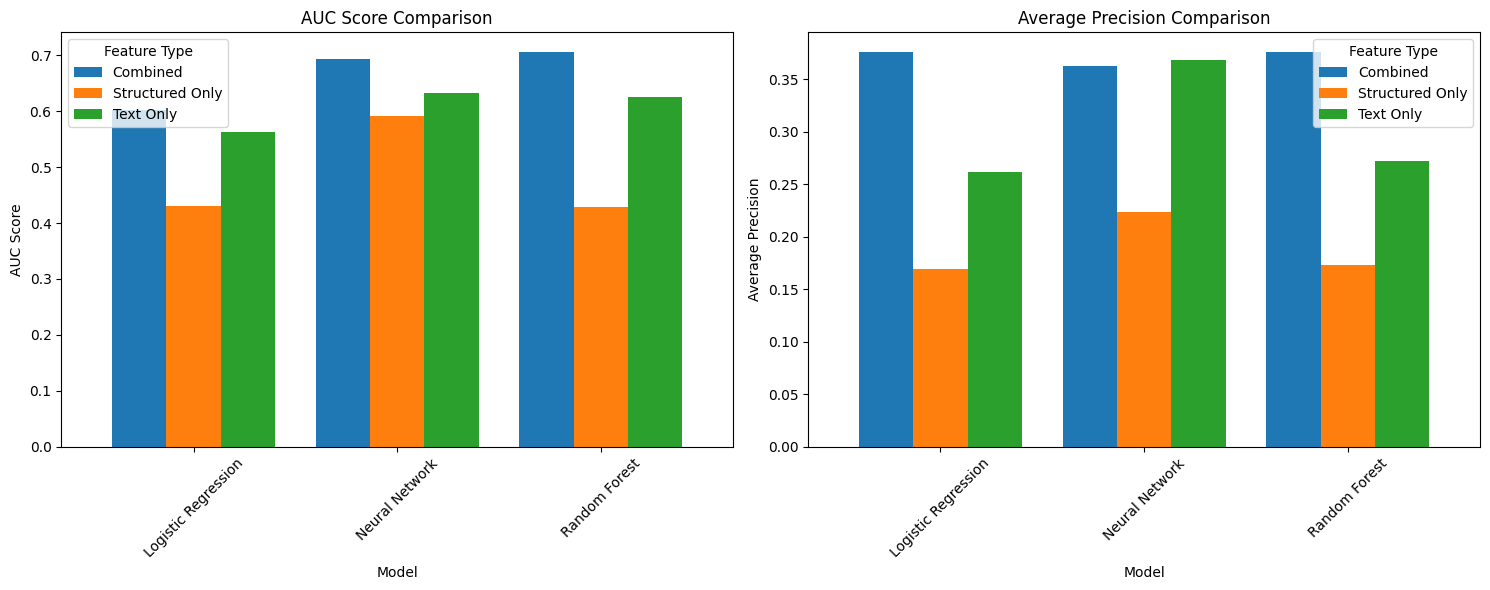


Detailed Performance Comparison:
                          AUC                           Avg_Precision  \
Feature_Type         Combined Structured Only Text Only      Combined   
Model                                                                   
Logistic Regression  0.601732        0.430736  0.562771      0.375745   
Neural Network       0.692641        0.590909  0.632035      0.362169   
Random Forest        0.705628        0.428571  0.625541      0.375761   

                                               
Feature_Type        Structured Only Text Only  
Model                                          
Logistic Regression        0.169108  0.261864  
Neural Network             0.223117  0.367804  
Random Forest              0.172903  0.272054  


In [8]:
# Create performance comparison
def create_performance_comparison(all_results):
    """Create a comprehensive performance comparison"""

    # Prepare data for visualization
    comparison_data = []

    for feature_type, models in all_results.items():
        for model_name, metrics in models.items():
            comparison_data.append({
                'Feature_Type': feature_type,
                'Model': model_name,
                'AUC': metrics['auc_score'],
                'Avg_Precision': metrics['avg_precision']
            })

    comparison_df = pd.DataFrame(comparison_data)

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # AUC comparison
    pivot_auc = comparison_df.pivot(index='Model', columns='Feature_Type', values='AUC')
    pivot_auc.plot(kind='bar', ax=axes[0], width=0.8)
    axes[0].set_title('AUC Score Comparison')
    axes[0].set_ylabel('AUC Score')
    axes[0].legend(title='Feature Type')
    axes[0].tick_params(axis='x', rotation=45)

    # Average Precision comparison
    pivot_ap = comparison_df.pivot(index='Model', columns='Feature_Type', values='Avg_Precision')
    pivot_ap.plot(kind='bar', ax=axes[1], width=0.8)
    axes[1].set_title('Average Precision Comparison')
    axes[1].set_ylabel('Average Precision')
    axes[1].legend(title='Feature Type')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return comparison_df

# Create comparison
comparison_df = create_performance_comparison(all_results)

# Display results table
print("\nDetailed Performance Comparison:")
print(comparison_df.pivot(index='Model', columns='Feature_Type', values=['AUC', 'Avg_Precision']))

## ROC Curves and Precision-Recall Curves

Let's visualize the ROC and Precision-Recall curves for the best performing models:

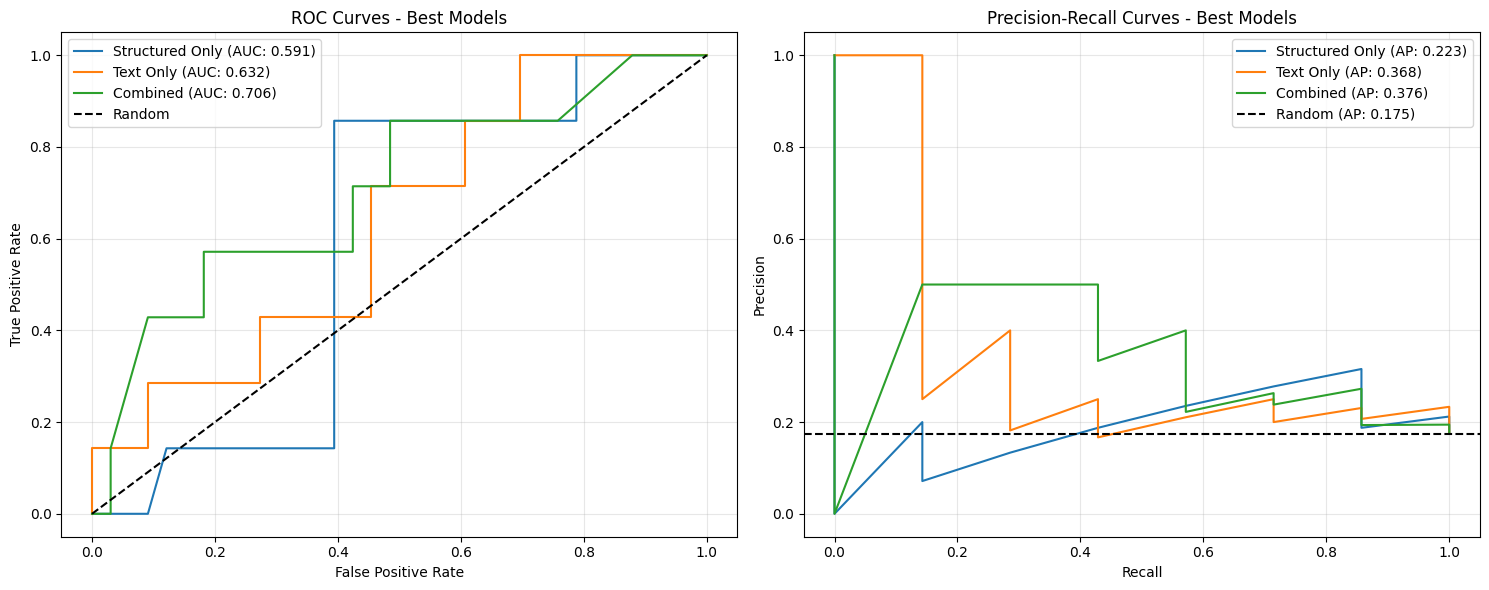

In [9]:
def plot_roc_and_pr_curves(all_results):
    """Plot ROC and Precision-Recall curves"""

    # Get the best model for each feature type
    best_models = {}
    for feature_type, models in all_results.items():
        best_auc = 0
        best_model_name = None
        for model_name, metrics in models.items():
            if metrics['auc_score'] > best_auc:
                best_auc = metrics['auc_score']
                best_model_name = model_name
        best_models[feature_type] = (best_model_name, models[best_model_name])

    # Plot curves
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # ROC Curves
    for feature_type, (model_name, metrics) in best_models.items():
        y_test = metrics['y_test']
        y_pred_proba = metrics['probabilities']

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        axes[0].plot(fpr, tpr, label=f'{feature_type} (AUC: {metrics["auc_score"]:.3f})')

    axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curves - Best Models')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Precision-Recall Curves
    for feature_type, (model_name, metrics) in best_models.items():
        y_test = metrics['y_test']
        y_pred_proba = metrics['probabilities']

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        axes[1].plot(recall, precision, label=f'{feature_type} (AP: {metrics["avg_precision"]:.3f})')

    # Random baseline
    random_precision = best_models['Combined'][1]['y_test'].mean()
    axes[1].axhline(y=random_precision, color='k', linestyle='--', label=f'Random (AP: {random_precision:.3f})')

    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curves - Best Models')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot curves
plot_roc_and_pr_curves(all_results)

## Feature Importance Analysis

Let's analyze the importance of different features in our models:

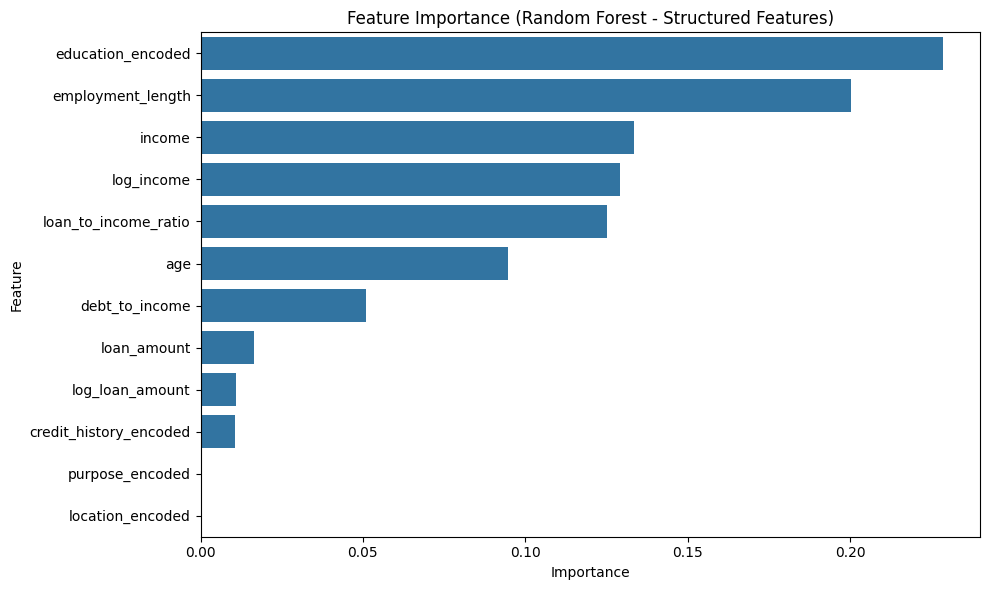


Top 10 Most Important Features:
                   Feature  Importance
10       education_encoded    0.228611
3        employment_length    0.200241
1                   income    0.133507
6               log_income    0.129243
5     loan_to_income_ratio    0.125169
0                      age    0.094613
4           debt_to_income    0.050852
2              loan_amount    0.016356
7          log_loan_amount    0.010852
9   credit_history_encoded    0.010555


In [10]:
def analyze_feature_importance(all_results, X_structured):
    """Analyze feature importance from different models"""

    # Get the best Random Forest model with structured features
    rf_model = all_results['Structured Only']['Random Forest']['model']

    # Get feature importance
    feature_importance = rf_model.feature_importances_
    feature_names = X_structured.columns

    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title('Feature Importance (Random Forest - Structured Features)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return importance_df

# Analyze feature importance
importance_df = analyze_feature_importance(all_results, X_structured)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

## Confusion Matrix Analysis

Let's examine the confusion matrices for our best models:

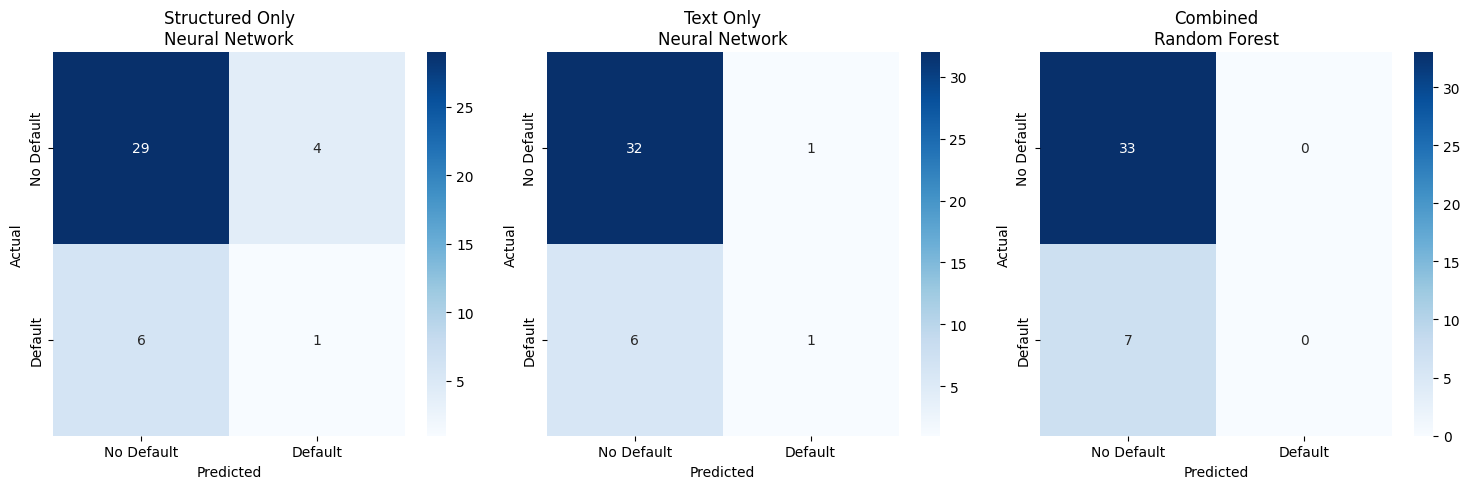

In [11]:
def plot_confusion_matrices(all_results):
    """Plot confusion matrices for the best models"""

    # Get the best model for each feature type
    best_models = {}
    for feature_type, models in all_results.items():
        best_auc = 0
        best_model_name = None
        for model_name, metrics in models.items():
            if metrics['auc_score'] > best_auc:
                best_auc = metrics['auc_score']
                best_model_name = model_name
        best_models[feature_type] = (best_model_name, models[best_model_name])

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, (feature_type, (model_name, metrics)) in enumerate(best_models.items()):
        y_test = metrics['y_test']
        y_pred = metrics['predictions']

        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Default', 'Default'],
                   yticklabels=['No Default', 'Default'],
                   ax=axes[idx])

        axes[idx].set_title(f'{feature_type}\n{model_name}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(all_results)

## Model Interpretability

Let's examine what the models have learned from the text data:

In [ ]:
def analyze_text_predictions(df, all_results, X_test_indices):
    """Analyze how text features affect predictions"""

    # Get predictions from different models
    structured_probs = all_results['Structured Only']['Logistic Regression']['probabilities']
    text_probs = all_results['Text Only']['Logistic Regression']['probabilities']
    combined_probs = all_results['Combined']['Logistic Regression']['probabilities']

    # Get the last test split (Combined features) for y_test
    y_test = all_results['Combined']['Logistic Regression']['y_test']

    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'structured_prob': structured_probs,
        'text_prob': text_probs,
        'combined_prob': combined_probs,
        'actual_default': y_test,
        'text_description': df.iloc[X_test_indices]['text_description'].values
    })

    # Find cases where text significantly changes prediction
    comparison_df['text_impact'] = comparison_df['combined_prob'] - comparison_df['structured_prob']

    # Most positive text impact (text increases default probability)
    print("Cases where text INCREASES default probability:")
    top_positive = comparison_df.nlargest(3, 'text_impact')
    for idx, row in top_positive.iterrows():
        print(f"\nStructured: {row['structured_prob']:.3f} -> Combined: {row['combined_prob']:.3f} (Impact: +{row['text_impact']:.3f})")
        print(f"Actual default: {row['actual_default']}")
        print(f"Text: {row['text_description'][:200]}...")

    # Most negative text impact (text decreases default probability)
    print("\n" + "="*80)
    print("Cases where text DECREASES default probability:")
    top_negative = comparison_df.nsmallest(3, 'text_impact')
    for idx, row in top_negative.iterrows():
        print(f"\nStructured: {row['structured_prob']:.3f} -> Combined: {row['combined_prob']:.3f} (Impact: {row['text_impact']:.3f})")
        print(f"Actual default: {row['actual_default']}")
        print(f"Text: {row['text_description'][:200]}...")

    # Visualization
    plt.figure(figsize=(12, 8))

    # Scatter plot of text impact
    plt.subplot(2, 2, 1)
    colors = ['blue' if x == 0 else 'red' for x in comparison_df['actual_default']]
    plt.scatter(comparison_df['structured_prob'], comparison_df['text_impact'],
               c=colors, alpha=0.6)
    plt.xlabel('Structured Probability')
    plt.ylabel('Text Impact')
    plt.title('Text Impact vs Structured Probability')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # Distribution of text impact
    plt.subplot(2, 2, 2)
    plt.hist(comparison_df['text_impact'], bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Text Impact')
    plt.ylabel('Frequency')
    plt.title('Distribution of Text Impact')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)

    # Probability comparison
    plt.subplot(2, 2, 3)
    plt.scatter(comparison_df['structured_prob'], comparison_df['combined_prob'],
               c=colors, alpha=0.6)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('Structured Probability')
    plt.ylabel('Combined Probability')
    plt.title('Structured vs Combined Probabilities')

    # Text vs structured probability
    plt.subplot(2, 2, 4)
    plt.scatter(comparison_df['text_prob'], comparison_df['structured_prob'],
               c=colors, alpha=0.6)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('Text Probability')
    plt.ylabel('Structured Probability')
    plt.title('Text vs Structured Probabilities')

    plt.tight_layout()
    plt.show()

## Save the Best Model

Let's save the best performing model for use in the next notebook:

In [13]:
import joblib

# Find the best overall model
best_overall_auc = 0
best_overall_model = None
best_overall_config = None

for feature_type, models in all_results.items():
    for model_name, metrics in models.items():
        if metrics['auc_score'] > best_overall_auc:
            best_overall_auc = metrics['auc_score']
            best_overall_model = metrics
            best_overall_config = (feature_type, model_name)

print(f"Best model: {best_overall_config[1]} with {best_overall_config[0]} features")
print(f"AUC Score: {best_overall_auc:.4f}")
print(f"Average Precision: {best_overall_model['avg_precision']:.4f}")

# Save the best model and preprocessing components
model_artifacts = {
    'model': best_overall_model['model'],
    'scaler': best_overall_model['scaler'],
    'feature_type': best_overall_config[0],
    'model_name': best_overall_config[1],
    'performance': {
        'auc_score': best_overall_auc,
        'avg_precision': best_overall_model['avg_precision']
    },
    'label_encoders': {
        'purpose': le_purpose,
        'credit_history': le_credit
    },
    'embeddings_info': {
        'model_used': 'text-embedding-3-small',
        'embedding_dimension': embeddings.shape[1],
        'api_provider': 'OpenAI'
    },
    'feature_columns': list(X_structured.columns)
}

# Save embeddings separately if using text features
if 'Text' in best_overall_config[0]:
    model_artifacts['embeddings'] = embeddings

# Save to file
joblib.dump(model_artifacts, '/content/drive/MyDrive/data/best_credit_risk_model.pkl')

print("\nModel saved successfully!")
print(f"Embedding model used: text-embedding-3-small")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Model artifacts saved to: best_credit_risk_model.pkl")

Best model: Random Forest with Combined features
AUC Score: 0.7056
Average Precision: 0.3758

Model saved successfully!
Embedding model used: text-embedding-3-small
Embedding dimension: 1536
Model artifacts saved to: best_credit_risk_model.pkl
